<a href="https://colab.research.google.com/github/ksnugroho/teori-praktik-cv-part1/blob/main/Bagian_2_Bab_5_5_4_Implementasi_Convolutional_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Mengunduh Dataset

In [ ]:
data_folder = './data/FMNIST'

train_data = datasets.FashionMNIST(data_folder, download=True, train=True)
val_data = datasets.FashionMNIST(data_folder, download=True, train=False)

tr_images, tr_targets = train_data.data, train_data.targets
val_images, val_targets = val_data.data, val_data.targets

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.5MB/s]


Extracting ./data/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FMNIST/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 168kB/s]


Extracting ./data/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FMNIST/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.24MB/s]


Extracting ./data/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FMNIST/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 24.2MB/s]

Extracting ./data/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FMNIST/FashionMNIST/raw



In [ ]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1, 1, 28, 28)
        self.x, self.y = x, y
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

# Melatih Model

In [ ]:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return trn_dl, val_dl

# Definisi model Convolutional Neural Network
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001)

    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    model.eval()
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

def val_loss(x, y, model):
    with torch.no_grad():
        prediction = model(x)
        val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [ ]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [ ]:
from torchsummary import summary

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 26, 26]             640
         MaxPool2d-2           [-1, 64, 13, 13]               0
              ReLU-3           [-1, 64, 13, 13]               0
            Conv2d-4          [-1, 128, 11, 11]          73,856
         MaxPool2d-5            [-1, 128, 5, 5]               0
              ReLU-6            [-1, 128, 5, 5]               0
           Flatten-7                 [-1, 3200]               0
            Linear-8                  [-1, 256]         819,456
              ReLU-9                  [-1, 256]               0
           Linear-10                   [-1, 10]           2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.69
Params size (MB): 3.42
Estimated T

In [ ]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(5):
    print(f"Epoch {epoch + 1}")
    train_epoch_losses, train_epoch_accuracies = [], []

    for x, y in trn_dl:
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for x, y in trn_dl:
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for x, y in val_dl:
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

    print(f"Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy:.4f}")
    print(f"Validation Loss: {validation_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}")

Epoch 1
Train Loss: 0.4360, Train Accuracy: 0.8900
Validation Loss: 0.3320, Validation Accuracy: 0.8816
Epoch 2
Train Loss: 0.2860, Train Accuracy: 0.9104
Validation Loss: 0.2916, Validation Accuracy: 0.8909
Epoch 3
Train Loss: 0.2365, Train Accuracy: 0.9259
Validation Loss: 0.2600, Validation Accuracy: 0.9026
Epoch 4
Train Loss: 0.2013, Train Accuracy: 0.9436
Validation Loss: 0.2388, Validation Accuracy: 0.9119
Epoch 5
Train Loss: 0.1702, Train Accuracy: 0.9453
Validation Loss: 0.2581, Validation Accuracy: 0.9076


<ipython-input-8-a750592e9e98>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])


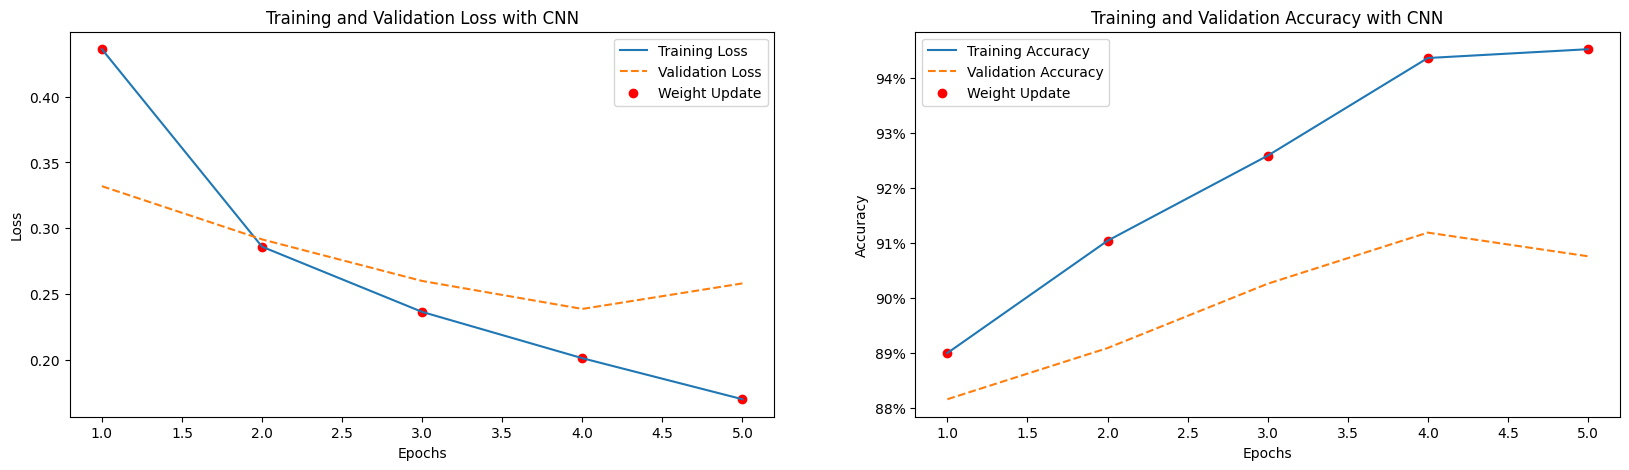

In [ ]:
epochs = np.arange(5) + 1

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss', linestyle='--')
plt.scatter(epochs, train_losses, color='red', label='Weight Update')
plt.title('Training and Validation Loss with CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', linestyle='--')
plt.scatter(epochs, train_accuracies, color='red', label='Weight Update')
plt.title('Training and Validation Accuracy with CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])
plt.legend()

plt.show()

# Menerapkan Translasi pada Gambar

Text(0.5, 1.0, 'Trouser')

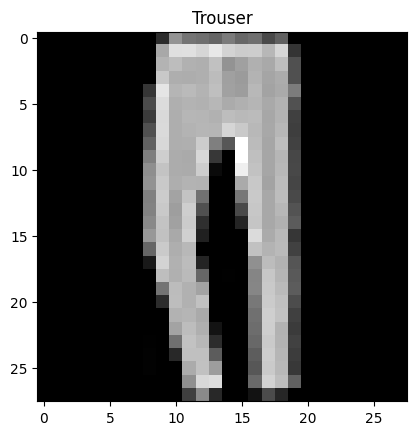

In [ ]:
ix = 24500 # Pilih acak index gambar dari data pelatihan

plt.imshow(tr_images[ix], cmap='gray')
plt.title(train_data.classes[tr_targets[ix]])

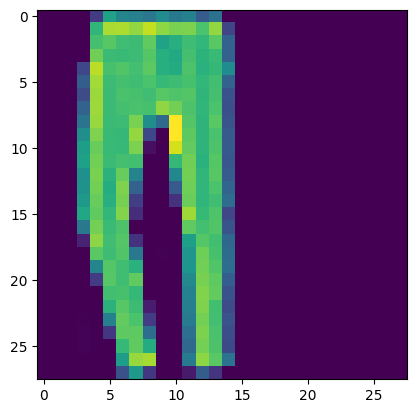

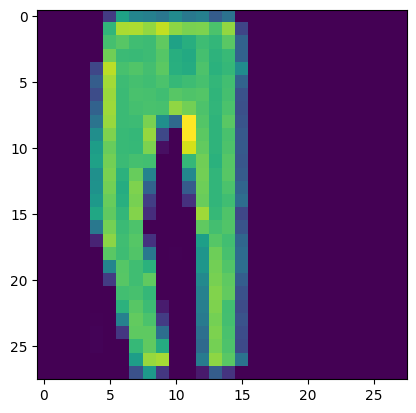

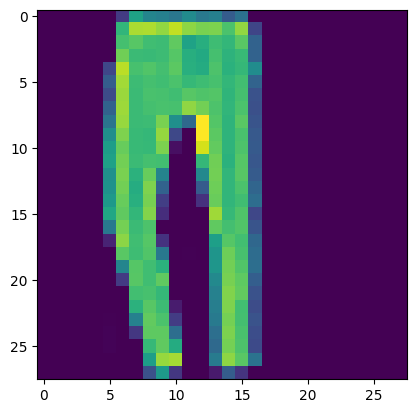

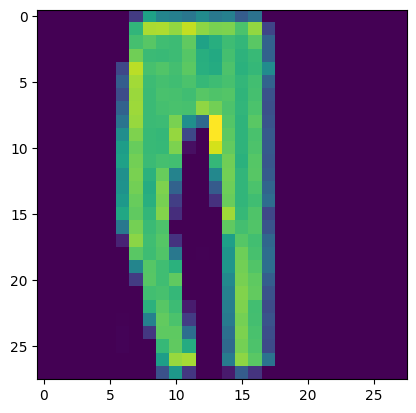

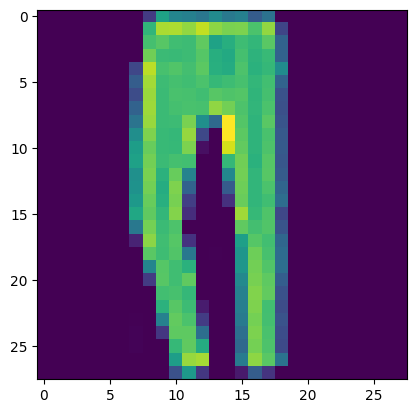

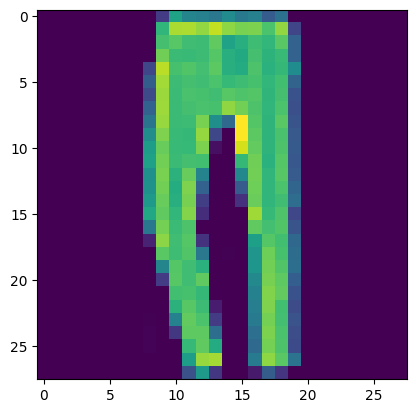

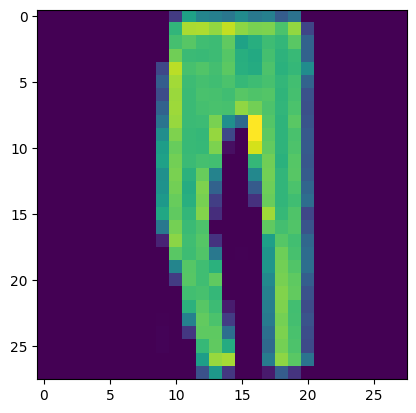

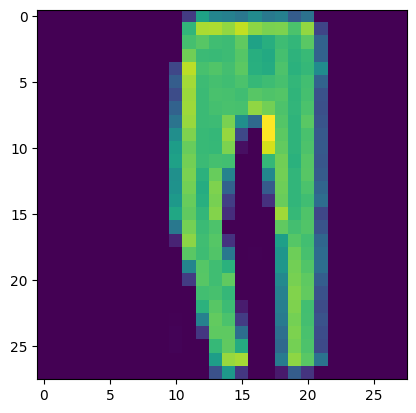

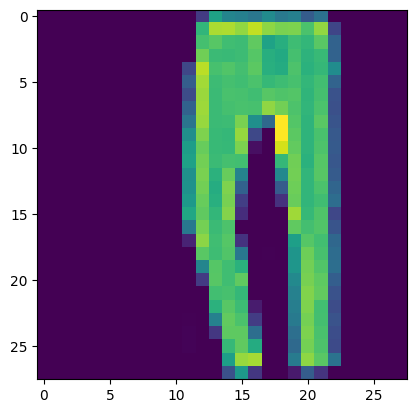

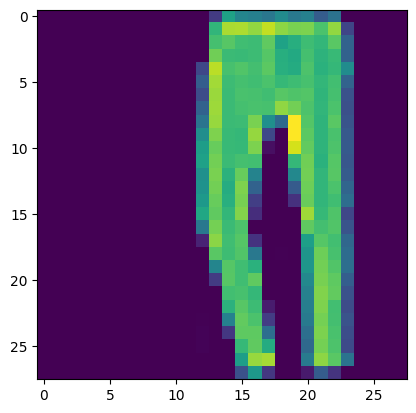

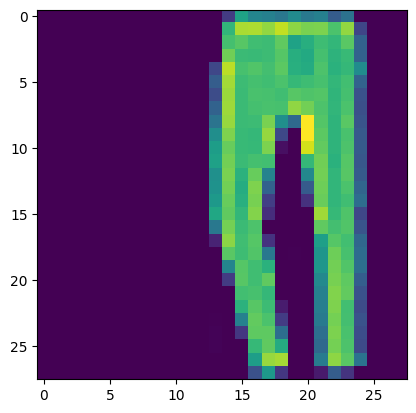

In [ ]:
preds = []

for px in range(-5, 6):
    img = tr_images[ix]/255.
    img = img.view(28, 28)
    img2 = np.roll(img, px, axis=1)
    img3 = torch.Tensor(img2).view(-1,1,28,28).to(device)
    np_output = model(img3).cpu().detach().numpy()
    pred = np.exp(np_output)/np.sum(np.exp(np_output))
    preds.append(pred)
    plt.imshow(img2)
    plt.show()

Text(0.5, 1.0, 'Probability of each class for various translations (CNN)')

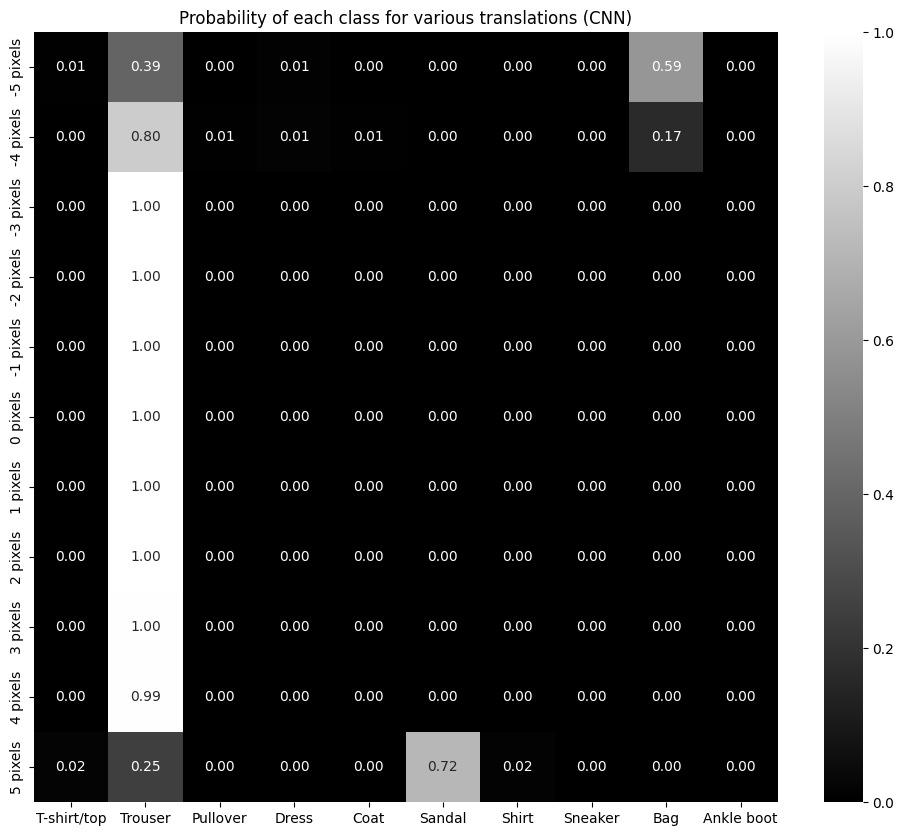

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,10))

sns.heatmap(np.array(preds).reshape(11,10), annot=True, ax=ax, fmt='.2f', xticklabels=train_data.classes, yticklabels=[str(i)+str(' pixels') for i in range(-5,6)], cmap='gray')
plt.title('Probability of each class for various translations (CNN)')